In [18]:
import os
from dotenv import load_dotenv
from pathlib import Path
import pandas as pd
import numpy as np

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# sklearn imports
import sklearn.preprocessing as preprocessing
import sklearn.model_selection as model_selection
import sklearn.linear_model as linear_model
import sklearn.metrics as metrics
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from mlxtend.evaluate import feature_importance_permutation

# imblearn imports
import imblearn.ensemble as ensemble
import imblearn.metrics as imblearn_metrics

In [19]:
# Functions

def increase_dummies(x):
    if x > 0:
        return 1
    else:
        return 0
    
def descending_sort_features(features, importances):
    indices = np.argsort(importances)
    
    sorted_importances = importances[indices[::-1]]
    sorted_features = features[indices[::-1]]
    
    result = np.dstack((sorted_features, sorted_importances))[0].tolist()
    
    return result

In [20]:
# read in saved csv

raw_path = Path('data/raw_nyt_watson.csv')
indices_path = Path('data/global_indicies.csv')

raw_df = pd.read_csv(raw_path, parse_dates=True, index_col='Date')
indices_df = pd.read_csv(indices_path)

In [21]:
# set indicies_df date index

indices_df["Date"] = pd.to_datetime(indices_df["Date"]).dt.date
indices_df = indices_df.set_index("Date")

In [22]:
# Pivot on Ticker

indices_pivot = indices_df.pivot(columns = "Ticker", values = "Close")

In [23]:
# Forward fill on any na in indices

indices_pivot = indices_pivot.fillna(method="ffill")

In [24]:
# Rename columns so its clear that these are closes

d = {
    'CAC' : 'CAC Close',
    'FTSE' : 'FTSE Close',
    'MDAX' : 'MDAX Close',
    'SP500' : 'SP500 Close',
    'TOPIX' : 'TOPIX Close'
}

indices_pivot = indices_pivot.rename(columns=d)

In [25]:
# Calculate percent change for each index

indices_pivot.insert(0, "TOPIX percent change", indices_pivot['TOPIX Close'].pct_change() * 100)
indices_pivot.insert(0, "SP500 percent change", indices_pivot['SP500 Close'].pct_change() * 100)
indices_pivot.insert(0, "MDAX percent change", indices_pivot['MDAX Close'].pct_change() * 100)
indices_pivot.insert(0, "FTSE percent change", indices_pivot['FTSE Close'].pct_change() * 100)
indices_pivot.insert(0, "CAC percent change", indices_pivot['CAC Close'].pct_change() * 100)

In [26]:
# create copy of read-in features

sentiment_df = raw_df.copy()

In [27]:
# drop unneccesary information

sentiment_df = sentiment_df.drop(columns=['Source', 'Headline', 'Lead Paragraph', 'URL'])

In [28]:
# get dummies

sentiment_df = pd.get_dummies(sentiment_df)

In [29]:
# group by date and take the mean of the sentiment scores

mean_sentiment_df = sentiment_df.groupby(['Date']).mean()

In [30]:
# concatenate the features and target data

mean_sentiment_df = pd.concat([indices_pivot.loc[:, "CAC percent change":"TOPIX percent change"], mean_sentiment_df], axis=1)

In [31]:
# create categories for the percent increase, 1 for increase, 0 for decrease/no change

mean_sentiment_df.insert(0, "TOPIX increase", mean_sentiment_df['TOPIX percent change'].apply(increase_dummies))
mean_sentiment_df.insert(0, "SP500 increase", mean_sentiment_df['SP500 percent change'].apply(increase_dummies))
mean_sentiment_df.insert(0, "MDAX increase", mean_sentiment_df['MDAX percent change'].apply(increase_dummies))
mean_sentiment_df.insert(0, "FTSE increase", mean_sentiment_df['FTSE percent change'].apply(increase_dummies))
mean_sentiment_df.insert(0, "CAC increase", mean_sentiment_df['CAC percent change'].apply(increase_dummies))

# create categories for the sentiment, 1 for positive, 0 for negative/neutral
mean_sentiment_df['Headline Sentiment'] = mean_sentiment_df["Headline Sentiment"].apply(increase_dummies)
mean_sentiment_df['Lead Paragraph Sentiment'] = mean_sentiment_df["Lead Paragraph Sentiment"].apply(increase_dummies)

In [32]:
# Drop na

mean_sentiment_df.dropna(inplace=True)

In [33]:
pct_columns = ["CAC percent change", "FTSE percent change", "MDAX percent change", "SP500 percent change", "TOPIX percent change"]
inc_columns = ["CAC increase", "FTSE increase", "MDAX increase", "SP500 increase", "TOPIX increase"]

# create dataframe for BalancedRandomForest
brf_df = mean_sentiment_df.drop(pct_columns, axis=1)

In [34]:
x_cols = [i for i in brf_df.columns if i not in inc_columns]

In [35]:
X = brf_df[x_cols]

brf_indices = {
    "CAC" : {},
    "FTSE" : {}, 
    "MDAX" : {}, 
    "SP500" : {}, 
    "TOPIX" : {},
}

brf_features = {}

for key in brf_indices.keys():
    brf_indices[key]["target"] = brf_df[key + " increase"]

In [36]:
# define scaler, split percentage, and random state
scaler = StandardScaler()
train_size = 0.7
rs = 1

In [37]:
brf_features["X train"], brf_features["X test"] = train_test_split(X, train_size=train_size, random_state=rs)

scaler.fit(brf_features["X train"])

brf_features["X train scaled"] = scaler.transform(brf_features["X train"])
brf_features["X test scaled"] = scaler.transform(brf_features["X test"])

brf = ensemble.BalancedRandomForestClassifier(n_estimators=10000, random_state=rs)

for key, brf_data in brf_indices.items():
    
    print("test 1")
    
    brf_data["y train"], brf_data["y test"] = train_test_split(brf_data["target"], train_size=train_size, random_state=rs)
    print("test 2")
    brf.fit(brf_features["X train scaled"], brf_data["y train"])
    
    print("test 3")
    
    brf_data["predictions"] = brf.predict(brf_features["X test scaled"])
    
    brf_data["Accuracy"] = metrics.balanced_accuracy_score(brf_data["y test"], brf_data["predictions"]) 
    
    brf_data["Confusion Matrix"] = metrics.confusion_matrix(brf_data["y test"], brf_data["predictions"])
    
    brf_data["Classification Report"] = imblearn_metrics.classification_report_imbalanced(
        brf_data["y test"], 
        brf_data["predictions"], 
        digits=4
    )
    
    brf_data["Feature Importance"] = descending_sort_features(
        brf_features["X train"].columns, 
        brf.feature_importances_
    )
    
del brf


test 1
test 2
test 3
test 1
test 2
test 3
test 1
test 2
test 3
test 1
test 2
test 3
test 1
test 2
test 3


In [38]:
for key, value in brf_indices.items():
    print(f"{key} Accuracy: {value['Accuracy']:.4f}\n")
    print(f"{key} Confusion Matrix: \n{value['Confusion Matrix']}\n")
    print(f"{key} Classification Report: \n{value['Classification Report']}\n")
    print(f"{key} Top Five features")
    
    for i in range(5):
        print(f"{value['Feature Importance'][i][0]}: {value['Feature Importance'][i][1]:.4f}")
        
    print("\n")

CAC Accuracy: 0.5343

CAC Confusion Matrix: 
[[22 13]
 [28 22]]

CAC Classification Report: 
                   pre       rec       spe        f1       geo       iba       sup

          0     0.4400    0.6286    0.4400    0.5176    0.5259    0.2818        35
          1     0.6286    0.4400    0.6286    0.5176    0.5259    0.2714        50

avg / total     0.5509    0.5176    0.5509    0.5176    0.5259    0.2757        85


CAC Top Five features
Headline Anger: 0.0853
Lead Paragraph Sadness: 0.0829
Headline Joy: 0.0814
Lead Paragraph Anger: 0.0793
Lead Paragraph Fear: 0.0769


FTSE Accuracy: 0.4338

FTSE Confusion Matrix: 
[[19 18]
 [31 17]]

FTSE Classification Report: 
                   pre       rec       spe        f1       geo       iba       sup

          0     0.3800    0.5135    0.3542    0.4368    0.4265    0.1848        37
          1     0.4857    0.3542    0.5135    0.4096    0.4265    0.1790        48

avg / total     0.4397    0.4235    0.4442    0.4215    0.4265    0.

In [39]:
indices_list = ['CAC', 'SP500', 'TOPIX', 'MDAX','FTSE']
accuracy_list = []
for i in indices_list:
    acc = brf_indices[i]['Accuracy']
    accuracy_list.append(acc)

In [40]:
brf_indices['CAC']['Feature Importance'][0]

['Headline Anger', 0.08532187901186973]

In [41]:
top_features_list = []
for i in indices_list:
    top_5_features = []
    for x in range(0,5):
        feat = brf_indices[i]['Feature Importance'][x][0]
        top_5_features.append(feat)
    top_features_list.append(top_5_features)

In [42]:
feat_dict = {indices_list[i]: top_features_list[i] for i in range(len(indices_list))}
df_feat = pd.DataFrame(data = feat_dict)
df_feat

,CAC,SP500,TOPIX,MDAX,FTSE
0,Headline Anger,Lead Paragraph Sadness,Section_Foreign,Section_Business,Headline Disgust
1,Lead Paragraph Sadness,Headline Disgust,Headline Joy,Headline Disgust,Lead Paragraph Sadness
2,Headline Joy,Lead Paragraph Disgust,Lead Paragraph Fear,Headline Anger,Lead Paragraph Joy
3,Lead Paragraph Anger,Headline Sadness,Lead Paragraph Sadness,Headline Joy,Headline Fear
4,Lead Paragraph Fear,Lead Paragraph Anger,Headline Anger,Lead Paragraph Anger,Section_Business


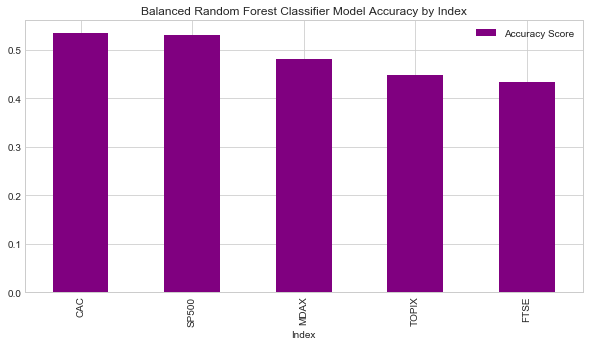

In [55]:
df_accuracy = pd.DataFrame(data = {'Index': indices_list, 'Accuracy Score': accuracy_list})
df_accuracy.set_index('Index', inplace = True)
df_accuracy.sort_values(by = 'Accuracy Score',ascending = False).plot(kind = 'bar', title = 'Balanced Random Forest Classifier Model Accuracy by Index' , color = 'purple', figsize = (10,5) 
                                                                     )

In [56]:
df_visual = pd.read_csv('data/raw_nyt_watson.csv')

In [57]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = [20.0, 10.0]
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
from string import punctuation
import re

In [58]:
lemmatizer = WordNetLemmatizer()

In [59]:
def tokenizer(text):
    sw = set(stopwords.words('english'))
    # Expand the default stopwords list if necessary
    sw_addons = {'economy','index', 'Date', 'file', 'photo', 'said','reuters', 'ruvicillustrationlondon', 'illustration', 'reutersdado', 'currency'}
    regex = re.compile("[^a-zA-Z ]")
    re_clean = regex.sub('', text)
    words = word_tokenize(re_clean)
    lem = [lemmatizer.lemmatize(word) for word in words]
    output = [word.lower() for word in lem if word.lower() not in sw.union(sw_addons)]
    return output

In [60]:
big_string_headline = ' '.join(df_visual['Headline'].tolist())

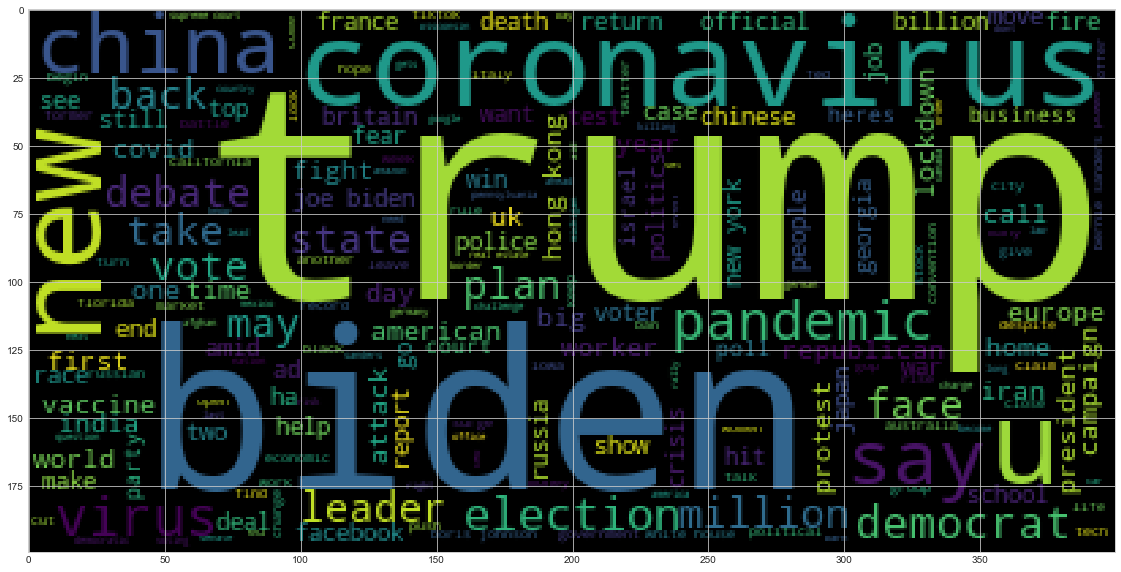

In [61]:
input_headline = ' '.join(tokenizer(big_string_headline))
wc_headline = WordCloud().generate(input_headline)
plt.imshow(wc_headline)